## Import Library:

In [1]:
import os # untuk berinteraksi dengan sistem operasi, seperti untuk mengakses file dan direktori
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # untuk membagi dataset menjadi subset training dan testing
import torch # Library utama PyTorch untuk komputasi tensor dan deep learning
from torch.utils.data import Dataset, DataLoader # Kelas untuk memanipulasi dataset dan membuat batch data untuk training
from torchvision import transforms # Modul untuk melakukan transformasi pada gambar seperti augmentasi data
import torch.nn as nn # Modul yang berisi berbagai komponen neural network seperti lapisan (layers), fungsi aktivasi, dll
import torch.optim as optim # Modul untuk algoritma optimasi, seperti SGD, Adam, dll
# from torchvision.models import resnet50 # Model pre-trained ResNet-50 yang bisa digunakan untuk tugas klasifikasi gambar
import torchvision.models as models
import time # Library untuk mengukur waktu eksekusi kode
from torch.autograd import Variable # Kelas yang membungkus tensor untuk melacak sejarah operasi dan menghitung gradient
from PIL import Image # Library untuk membuka, memanipulasi, dan menyimpan gambar
from sklearn.metrics import classification_report, confusion_matrix # Fungsi untuk menghitung dan menampilkan laporan klasifikasi dan confusion matrix
import cv2 # Library OpenCV untuk manipulasi gambar dan video
from torchvision.io import read_image

## Data Preparation:

In [2]:
data_path = '/kaggle/input/celeba-face-recognition/Dataset Project 1 Face Recognition' # Menyimpan path ke direktori dataset CelebA

In [3]:
os.listdir(data_path) # Mengambil daftar semua file dan folder dalam direktori yang ditentukan

['Model Saved',
 'gender_classification.xlsx',
 'gender_classification.csv',
 'Images',
 'list_attribute_edit.txt',
 'class_identity.txt']

In [4]:
images_list = os.listdir(data_path +'/Images') # Mengambil daftar semua file dalam subdirektori Images dari data_path
images_list = [i for i in images_list if len(i) < 11] # Because there are Duplicate Images 'XXXXXX(1).jpg'
images_list.sort()

**Keterangan Kode:**

- images_list = [i for i in images_list if len(i) < 11]: Membuat daftar baru images_list yang hanya berisi nama file gambar dengan panjang kurang dari 11 karakter. Hal ini dilakukan untuk menghapus gambar duplikat yang memiliki format nama 'XXXXXX(1).jpg'.
- images_list.sort(): Mengurutkan daftar gambar images_list secara alfabetis

In [5]:
data = pd.DataFrame(pd.read_csv(data_path + '/list_attribute_edit.txt', sep = '\s+', header = 0))
data = data[['file_name', 'Male']]
new_data =  data[data['file_name'].isin(images_list)] # filter the data with available images only (5000 images)
new_data = new_data.replace(-1, 0)

In [6]:
new_data.head()

,file_name,Male
50,000051.jpg,1
51,000052.jpg,1
64,000065.jpg,1
165,000166.jpg,1
197,000198.jpg,0


In [7]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 50 to 202565
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5000 non-null   object
 1   Male       5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.2+ KB


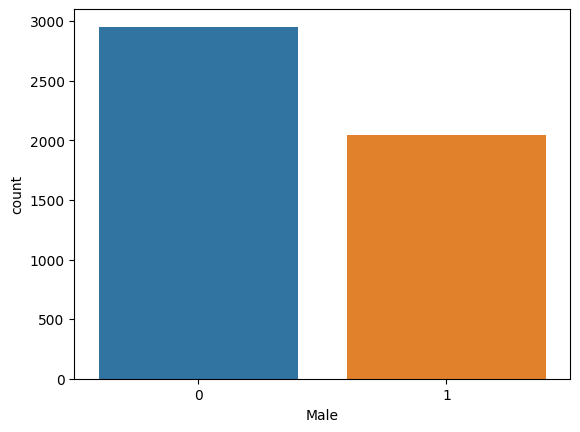

In [8]:
sns.countplot(x = new_data['Male']);

In [9]:
data.describe()

,Male
count,202599.000000
mean,-0.166491
std,0.986045
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,1.000000
max,1.000000


In [10]:
new_data.describe()

,Male
count,5000.000000
mean,0.409400
std,0.491772
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
new_data_male = new_data[new_data['Male'] == 1]
new_data_female = new_data[new_data['Male'] == 0]
new_data_male = new_data_male.sample(frac = 1, random_state = 42)
new_data_female = new_data_female.sample(frac = 1, random_state = 42)

In [12]:
train_data = pd.concat([new_data_male[:1500], new_data_female[:1500]], axis = 0)
test_data = pd.concat([new_data_male[1500:], new_data_female[1500:]], axis = 0)
train_data.sort_index(inplace = True)
test_data.sort_index(inplace = True)
del new_data_male
del new_data_female

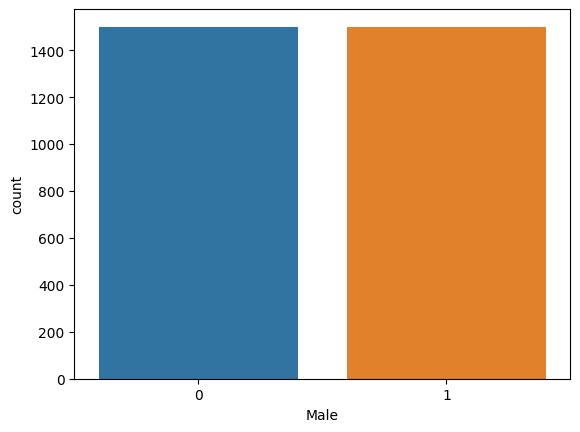

In [13]:
sns.countplot(x = train_data['Male']);

## Data Preprocessing:

In [14]:
train_data.iloc[0, 0]

'000051.jpg'

In [15]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform = None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        
        # Load Image and Convert to RGB:
#         try:
#             image = Image.open(image_path).convert('RGB')
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#             return None, None
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(gender, dtype = torch.long)

In [16]:
# Define the Transformations:
transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [17]:
train_set = GenderDataset(train_data, image_folder_path = os.path.join(data_path, "Images"), transform = transforms['train'])
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 2)

In [18]:
test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform = transforms['test'])
test_loader = DataLoader(test_set, batch_size = 32, shuffle = False, num_workers = 2)

In [19]:
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_set), 'test': len(test_set)}

## Architecture:

In [20]:
from torchvision.models import VGG11_Weights

# Define the Model (VGG-11) with updated weights parameter:
model = models.vgg11(weights = VGG11_Weights.DEFAULT)  # Using updated weights parameter
num_ftrs = model.classifier[6].in_features
# Adjust the final layer for Binary Classification:
model.classifier[6] = nn.Linear(num_ftrs, 1)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 156MB/s]  


In [21]:
# Define the Optimizer:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [22]:
# Define the Loss Function:
criterion = nn.BCEWithLogitsLoss()  # More stable than BCELoss for Binary Classification

In [23]:
# Move the Model to GPU if Available:
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.to('cuda')

## Modeling:

In [24]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu = torch.cuda.is_available(), num_epochs = 25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a Training and Validation Phase:
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to Training Mode
            else:
                model.train(False)  # Set model to Evaluate Mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate Over Data:
            for data in dataloaders[phase]:
                # Get the Inputs:
                inputs, labels = data

                # Wrap them in Variable:
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the Parameter Gradients:
                optimizer.zero_grad()

                # Forward:
                outputs = model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels.float())

                # Backward + Optimize Only if in Training Phase:
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics:
                running_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep Copy the Model:
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'/kaggle/working/model_best.pth')
                
            if phase == 'test':
                last_acc = epoch_acc
                last_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'/kaggle/working/model_last.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # Load Best Model Weights:
    model.load_state_dict(best_model_wts)
    return model

In [25]:
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 25)

Epoch 0/24
----------
train Loss: 0.2839 Acc: 0.8690
test Loss: 0.3019 Acc: 0.8705

Epoch 1/24
----------
train Loss: 0.1690 Acc: 0.9330
test Loss: 0.2131 Acc: 0.9270

Epoch 2/24
----------
train Loss: 0.1238 Acc: 0.9563
test Loss: 0.2393 Acc: 0.9230

Epoch 3/24
----------
train Loss: 0.0925 Acc: 0.9627
test Loss: 0.0969 Acc: 0.9695

Epoch 4/24
----------
train Loss: 0.1012 Acc: 0.9640
test Loss: 0.0954 Acc: 0.9645

Epoch 5/24
----------
train Loss: 0.0772 Acc: 0.9687
test Loss: 0.0856 Acc: 0.9705

Epoch 6/24
----------
train Loss: 0.0527 Acc: 0.9797
test Loss: 0.1024 Acc: 0.9675

Epoch 7/24
----------
train Loss: 0.0469 Acc: 0.9843
test Loss: 0.1636 Acc: 0.9505

Epoch 8/24
----------
train Loss: 0.0595 Acc: 0.9773
test Loss: 0.1100 Acc: 0.9560

Epoch 9/24
----------
train Loss: 0.0494 Acc: 0.9823
test Loss: 0.1026 Acc: 0.9670

Epoch 10/24
----------
train Loss: 0.0495 Acc: 0.9810
test Loss: 0.1212 Acc: 0.9610

Epoch 11/24
----------
train Loss: 0.0475 Acc: 0.9847
test Loss: 0.0911 Acc

## Evaluation:

In [26]:
# For if Loading Weights onto a Model, otherwise keep commented:
model.load_state_dict(torch.load('/kaggle/working/model_last.pth')['model'])
if torch.cuda.is_available():
  model = model.to("cuda")

In [27]:
y_true = torch.empty((0)).cuda()
y_pred = torch.empty((0)).cuda()
for data in dataloaders['test']: 
      inputs, labels = data
      #print(labels)
      if torch.cuda.is_available():
          inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      else:
          inputs, labels = Variable(inputs), Variable(labels)
      #print(labels)
      #_, lab = torch.max(labels.data, 1)
      outputs = model(inputs)
      #print(outputs)
      preds = (torch.sigmoid(outputs).squeeze() > 0.5).float()
      y_true = torch.cat((y_true, labels.data), -1)
      y_pred = torch.cat((y_pred, preds), -1)


In [28]:
y_true_np = y_true.detach().cpu().numpy()
y_pred_np = y_pred.detach().cpu().numpy()
print(classification_report(y_true_np, y_pred_np, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9909    0.9697    0.9802      1453
         1.0     0.9239    0.9762    0.9493       547

    accuracy                         0.9715      2000
   macro avg     0.9574    0.9730    0.9648      2000
weighted avg     0.9725    0.9715    0.9717      2000



## Latency Time:

In [29]:
!lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             4
On-line CPU(s) list:                0-3
Thread(s) per core:                 2
Core(s) per socket:                 2
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                           3
CPU MHz:                            2000.142
BogoMIPS:                           4000.28
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          64 KiB
L1i cache:                          64 KiB
L2 cache:                           2 MiB
L3 cache:                  

In [30]:
!nvidia-smi

Thu Jun 20 03:29:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |   5959MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [31]:
# Define a Sample Input Tensor to Warm up the Computation:
input_tensor = torch.rand(1, 3, 224, 224)

In [32]:
# Warm Up the Computation for GPU:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    input_tensor = input_tensor.to(device)
    for i in range(10):
        output = model(input_tensor)

In [33]:
# Test Inference Time for GPU:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    input_tensor = input_tensor.to(device)
    for i in range(100):
        start_time = time.time()
        output = model(input_tensor)
    end_time = time.time()
    print(f"Inference time for GPU: {end_time - start_time:.4f} seconds")

Inference time for GPU: 0.0059 seconds


In [34]:
# Test Inference Time for CPU:
device = torch.device("cpu")
model.to(device)
input_tensor = input_tensor.to(device)
for i in range(100):
    start_time = time.time()
    output = model(input_tensor)
end_time = time.time()
print(f"Inference time for CPU: {end_time - start_time:.4f} seconds")

Inference time for CPU: 0.1249 seconds
